In [4]:
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
from pyhive import hive

# Set python variables from environment variables
username = os.environ['USERNAME']
hive_host = os.environ['HIVE_SERVER2'].split(':')[0]
hive_port = os.environ['HIVE_SERVER2'].split(':')[1]

# create connection
conn = hive.connect(
    host=hive_host,
    port=hive_port)

# create cursor
cur = conn.cursor()

print(f"your username is {username}")
print(f"you are connected to {hive_host}:{hive_port}")

your username is lmarchan
you are connected to iccluster044.iccluster.epfl.ch:10000


In [3]:
query = f'CREATE DATABASE IF NOT EXISTS {username}'
cur.execute(query)

In [4]:
query = f"USE {username}"
cur.execute(query)

In [9]:
%load_ext sparkmagic.magics

Cleaning up livy sessions on exit is enabled


In [10]:
from IPython import get_ipython
username = os.environ['RENKU_USERNAME']
server = "http://iccluster044.iccluster.epfl.ch:8998"

# set the application name as "<your_gaspar_id>-homework3"
get_ipython().run_cell_magic(
    'spark',
    line='config', 
    cell="""{{ "name": "{0}-final-project2", "executorMemory": "4G", "executorCores": 4, "numExecutors": 10, "driverMemory": "4G" }}""".format(username)
)

In [11]:
get_ipython().run_line_magic(
    "spark", f"""add -s {username}-final-project2 -l python -u {server} -k"""
)

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
6138,application_1680948035106_5611,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


In [13]:
%%spark
#load a istdaten with the only the stops around 18km around Zurich
df_valid = spark.read.orc(f"/user/epple/hive/sbb_orc_istdaten_new")
df_valid.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

883241383

In [14]:
%%spark
df = df_valid.sample(0.01)  #we work on a sample of 1% of istdaten randomly chosen
df.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

8837471

In [16]:
%%spark
import pyspark.sql.functions as F
from pyspark.sql import DataFrameStatFunctions
import pandas as pd
from pyspark.sql.functions import col, lower, to_timestamp, date_format, avg, hour

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
%%spark
#compute the delays actual_arrival - expected_arrival
df_delays = df.select('*', (F.unix_timestamp(F.to_timestamp(df.an_prognose, format ='dd.MM.yyyy HH:mm:ss')) - F.unix_timestamp(F.to_timestamp(df.ankunftszeit,format ='dd.MM.yyyy HH:mm'))).alias('delay'))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
%%spark
#select only the useful columns stop_id, type of transport, stop name, expected_arrival, actual_arrival, delay 
ls = ['fahrt_bezeichner','produkt_id', 'haltestellen_name', 'ankunftszeit', 'an_prognose', 'delay']
df_delays_filter = df_delays.select(ls)
df_delays_filter.show(10) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+----------+-----------------+----------------+-------------------+-----+
|fahrt_bezeichner|produkt_id|haltestellen_name|    ankunftszeit|        an_prognose|delay|
+----------------+----------+-----------------+----------------+-------------------+-----+
| 85:11:18220:003|       Zug|      Zürich Enge|11.09.2018 06:06|11.09.2018 06:05:38|  -22|
| 85:11:18220:003|       Zug|        Zürich HB|11.09.2018 06:12|11.09.2018 06:11:14|  -46|
| 85:11:18232:002|       Zug|        Altendorf|11.09.2018 08:32|11.09.2018 08:33:07|   67|
| 85:11:18248:002|       Zug|           Horgen|11.09.2018 12:53|11.09.2018 12:53:08|    8|
| 85:11:18248:002|       Zug|      Zürich Enge|11.09.2018 13:06|11.09.2018 13:05:23|  -37|
| 85:11:18256:002|       Zug|           Horgen|11.09.2018 14:53|11.09.2018 14:53:14|   14|
| 85:11:18257:001|       Zug|      Zürich Enge|11.09.2018 15:22|11.09.2018 15:22:09|    9|
| 85:11:18257:001|       Zug|        Altendorf|11.09.2018 15:54|11.09.2018 15:54:03|    3|

In [20]:
%%spark
#change the negative delays to 0
df_delays_filter = df_delays_filter.withColumn("positive_delay", F.when(df_delays.delay > 0, df_delays.delay).otherwise(0))
df_delays_filter.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+----------+-----------------+----------------+-------------------+-----+--------------+
|fahrt_bezeichner|produkt_id|haltestellen_name|    ankunftszeit|        an_prognose|delay|positive_delay|
+----------------+----------+-----------------+----------------+-------------------+-----+--------------+
| 85:11:18220:003|       Zug|      Zürich Enge|11.09.2018 06:06|11.09.2018 06:05:38|  -22|             0|
| 85:11:18220:003|       Zug|        Zürich HB|11.09.2018 06:12|11.09.2018 06:11:14|  -46|             0|
| 85:11:18232:002|       Zug|        Altendorf|11.09.2018 08:32|11.09.2018 08:33:07|   67|            67|
| 85:11:18248:002|       Zug|           Horgen|11.09.2018 12:53|11.09.2018 12:53:08|    8|             8|
| 85:11:18248:002|       Zug|      Zürich Enge|11.09.2018 13:06|11.09.2018 13:05:23|  -37|             0|
| 85:11:18256:002|       Zug|           Horgen|11.09.2018 14:53|11.09.2018 14:53:14|   14|            14|
| 85:11:18257:001|       Zug|      Zürich Enge

In [22]:
%%spark
#change the type of transport to lowercase because there are 2 types bus (BUS, bus)
df_delays_filter = df_delays_filter.withColumn('produkt_id', lower(col('produkt_id')));
df_delays_filter.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+----------+-----------------+----------------+-------------------+-----+--------------+
|fahrt_bezeichner|produkt_id|haltestellen_name|    ankunftszeit|        an_prognose|delay|positive_delay|
+----------------+----------+-----------------+----------------+-------------------+-----+--------------+
| 85:11:18220:003|       zug|      Zürich Enge|11.09.2018 06:06|11.09.2018 06:05:38|  -22|             0|
| 85:11:18220:003|       zug|        Zürich HB|11.09.2018 06:12|11.09.2018 06:11:14|  -46|             0|
| 85:11:18232:002|       zug|        Altendorf|11.09.2018 08:32|11.09.2018 08:33:07|   67|            67|
| 85:11:18248:002|       zug|           Horgen|11.09.2018 12:53|11.09.2018 12:53:08|    8|             8|
| 85:11:18248:002|       zug|      Zürich Enge|11.09.2018 13:06|11.09.2018 13:05:23|  -37|             0|
+----------------+----------+-----------------+----------------+-------------------+-----+--------------+
only showing top 5 rows

In [23]:
%%spark
#remove the rows without data on delays
df_delays_filter = df_delays_filter.filter(col("delay").isNotNull())
df_delays_filter.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+----------+-----------------+----------------+-------------------+-----+--------------+
|fahrt_bezeichner|produkt_id|haltestellen_name|    ankunftszeit|        an_prognose|delay|positive_delay|
+----------------+----------+-----------------+----------------+-------------------+-----+--------------+
| 85:11:18220:003|       zug|      Zürich Enge|11.09.2018 06:06|11.09.2018 06:05:38|  -22|             0|
| 85:11:18220:003|       zug|        Zürich HB|11.09.2018 06:12|11.09.2018 06:11:14|  -46|             0|
| 85:11:18232:002|       zug|        Altendorf|11.09.2018 08:32|11.09.2018 08:33:07|   67|            67|
| 85:11:18248:002|       zug|           Horgen|11.09.2018 12:53|11.09.2018 12:53:08|    8|             8|
| 85:11:18248:002|       zug|      Zürich Enge|11.09.2018 13:06|11.09.2018 13:05:23|  -37|             0|
+----------------+----------+-----------------+----------------+-------------------+-----+--------------+
only showing top 5 rows

In [25]:
%%spark
#add a column with the day of the week
df_days_w = df_delays_filter.withColumn("an_prognose",F.to_timestamp(col("an_prognose"), format ='dd.MM.yyyy HH:mm:ss')).withColumn("week_day_abb", date_format(col("an_prognose"), "E"))
df_days_w.show(5)



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+----------+-----------------+----------------+-------------------+-----+--------------+------------+
|fahrt_bezeichner|produkt_id|haltestellen_name|    ankunftszeit|        an_prognose|delay|positive_delay|week_day_abb|
+----------------+----------+-----------------+----------------+-------------------+-----+--------------+------------+
| 85:11:18220:003|       zug|      Zürich Enge|11.09.2018 06:06|2018-09-11 06:05:38|  -22|             0|         Tue|
| 85:11:18220:003|       zug|        Zürich HB|11.09.2018 06:12|2018-09-11 06:11:14|  -46|             0|         Tue|
| 85:11:18232:002|       zug|        Altendorf|11.09.2018 08:32|2018-09-11 08:33:07|   67|            67|         Tue|
| 85:11:18248:002|       zug|           Horgen|11.09.2018 12:53|2018-09-11 12:53:08|    8|             8|         Tue|
| 85:11:18248:002|       zug|      Zürich Enge|11.09.2018 13:06|2018-09-11 13:05:23|  -37|             0|         Tue|
+----------------+----------+-----------------+-

In [26]:
%%spark
#create a list with all the days of the week
days =df_days_w.select('week_day_abb').distinct().rdd.flatMap(lambda x: x).collect()
print(days)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['Sun', 'Mon', 'Thu', 'Sat', 'Wed', 'Fri', 'Tue']

In [27]:
%%spark
#create a list with all the type of transport
#we do not consider the funicular
ttype = df_delays_filter.select('produkt_id').distinct().rdd.flatMap(lambda x: x).collect()
ttype = ttype[:3]
print(ttype)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['bus', 'zug', 'tram']

In [34]:
%%spark
#extract the hours of the trip
df_days_w =df_days_w.withColumn("hours", hour(col("an_prognose")))
df_days_w.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+----------+-----------------+----------------+-------------------+-----+--------------+------------+-----+
|fahrt_bezeichner|produkt_id|haltestellen_name|    ankunftszeit|        an_prognose|delay|positive_delay|week_day_abb|hours|
+----------------+----------+-----------------+----------------+-------------------+-----+--------------+------------+-----+
| 85:11:18220:003|       zug|      Zürich Enge|11.09.2018 06:06|2018-09-11 06:05:38|  -22|             0|         Tue|    6|
| 85:11:18220:003|       zug|        Zürich HB|11.09.2018 06:12|2018-09-11 06:11:14|  -46|             0|         Tue|    6|
| 85:11:18232:002|       zug|        Altendorf|11.09.2018 08:32|2018-09-11 08:33:07|   67|            67|         Tue|    8|
| 85:11:18248:002|       zug|           Horgen|11.09.2018 12:53|2018-09-11 12:53:08|    8|             8|         Tue|   12|
| 85:11:18248:002|       zug|      Zürich Enge|11.09.2018 13:06|2018-09-11 13:05:23|  -37|             0|         Tue|   13|


In [36]:
%%spark
# create a list called combinations with all the possible combinations 
# create a list called bacth with all delays threshold between 0 to 200s in range of 20s
batch = list(range(0,220,20))
comb = []
for i in range(len(batch)-1):
    tmp = str(batch[i]) + "-" + str(batch[i+1])
    comb.append(tmp)  # create a list with 2 batch together 
    
days = ['Mon', 'Tue', 'Wed', 'Thu','Fri', 'Sat', 'Sun']
ttype = ['bus', 'tram', 'zug']
hours_merge = ['6h-9h', '9h-16h','16-21h']
hours = [6,9,16,21]


combinations = []  #will be a list with all the possible combinations between the days, type of transport and moment in the day 
for week in days:
    for type in ttype:
        for h in hours_merge:
            # Create a combination by concatenating the week name and type
            combination = week + " - " + type + " " + h
            # Add the combination to the list
            combinations.append(combination)  


columns = comb
rows = combinations

# create an empty df to store all the info we will collect for the statistics
df_stat_ist = pd.DataFrame(columns=columns, index=rows)   #create an empty dataframe with all the combinations as rows and the batch as columns
df_stat_ist.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['0-20', '20-40', '40-60', '60-80', '80-100', '100-120', '120-140', '140-160', '160-180', '180-200']
                  0-20 20-40 40-60 60-80  ... 120-140 140-160 160-180 180-200
Mon - bus 6h-9h    NaN   NaN   NaN   NaN  ...     NaN     NaN     NaN     NaN
Mon - bus 9h-16h   NaN   NaN   NaN   NaN  ...     NaN     NaN     NaN     NaN
Mon - bus 16-21h   NaN   NaN   NaN   NaN  ...     NaN     NaN     NaN     NaN
Mon - tram 6h-9h   NaN   NaN   NaN   NaN  ...     NaN     NaN     NaN     NaN
Mon - tram 9h-16h  NaN   NaN   NaN   NaN  ...     NaN     NaN     NaN     NaN
Mon - tram 16-21h  NaN   NaN   NaN   NaN  ...     NaN     NaN     NaN     NaN
Mon - zug 6h-9h    NaN   NaN   NaN   NaN  ...     NaN     NaN     NaN     NaN
Mon - zug 9h-16h   NaN   NaN   NaN   NaN  ...     NaN     NaN     NaN     NaN
Mon - zug 16-21h   NaN   NaN   NaN   NaN  ...     NaN     NaN     NaN     NaN
Tue - bus 6h-9h    NaN   NaN   NaN   NaN  ...     NaN     NaN     NaN     NaN

[10 rows x 10 columns]

In [37]:
%%spark
#fill out the dataframe
k = 0
for idx,day in enumerate(days):
    for idx2,t in enumerate(ttype):
        w = 0
        for h in range(len(hours)-1):
            for i in range(len(batch)-1):
                number = df_days_w.filter((df_days_w.positive_delay >= batch[i] ) & (df_days_w.positive_delay < batch[i+1]) & (df_days_w.week_day_abb == day) & (df_days_w.produkt_id == t ) & (df_days_w.hours >= hours[h] ) & (df_days_w.hours < hours[h+1]) ).count()
                df_stat_ist.iloc[k+w,i] = number
            w = w + 1
        k = k + 3
df_stat_ist.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                    0-20  20-40  40-60  60-80  ... 120-140 140-160 160-180 180-200
Mon - bus 6h-9h    37195  26590  33541  27121  ...   12157    8511    5902    4203
Mon - bus 9h-16h   72649  52743  66104  54674  ...   24634   17319   11806    8184
Mon - bus 16-21h   62620  40909  49026  39209  ...   19197   14119   10403    7927
Mon - tram 6h-9h   15055   7783   8316   4889  ...    1623    1110     751     518
Mon - tram 9h-16h  38954  19274  19353  10459  ...    3096    2026    1343     907

[5 rows x 10 columns]

In [40]:
%%spark -o df_istaden_stat -n -1
df_istaden_stat = spark.createDataFrame(df_stat_ist.reset_index())  # transfer into a spark df and save it

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
df_istaden_stat.to_csv("stat_timeday.csv")

In [5]:
#load the df with all the statistics
stat_istdaten = pd.read_csv('stat_timeday.csv')
indexx = stat_istdaten['index']
stat_istdaten.head()

,Unnamed: 0,index,0-20,20-40,40-60,60-80,80-100,100-120,120-140,140-160,160-180,180-200
0,0,Mon - bus 6h-9h,37195,26590,33541,27121,23985,16472,12157,8511,5902,4203
1,1,Mon - bus 9h-16h,72649,52743,66104,54674,48090,33701,24634,17319,11806,8184
2,2,Mon - bus 16-21h,62620,40909,49026,39209,35376,24895,19197,14119,10403,7927
3,3,Mon - tram 6h-9h,15055,7783,8316,4889,3837,2358,1623,1110,751,518
4,4,Mon - tram 9h-16h,38954,19274,19353,10459,8131,4702,3096,2026,1343,907


In [9]:
#remove useless columns
stat_istdaten.drop(['Unnamed: 0', 'index'],axis=1, inplace=True)
stat_istdaten.head()

,0-20,20-40,40-60,60-80,80-100,100-120,120-140,140-160,160-180,180-200
0,37195,26590,33541,27121,23985,16472,12157,8511,5902,4203
1,72649,52743,66104,54674,48090,33701,24634,17319,11806,8184
2,62620,40909,49026,39209,35376,24895,19197,14119,10403,7927
3,15055,7783,8316,4889,3837,2358,1623,1110,751,518
4,38954,19274,19353,10459,8131,4702,3096,2026,1343,907


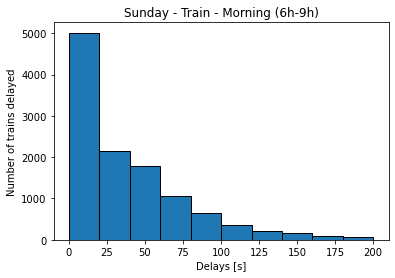

In [43]:
#check if the statistics we computed on istdaten make sense by plotting the distribution on 1 line
frequencies = stat_istdaten.iloc[60].tolist()[0:]
bin_ranges = list(range(0,220,20))
bin_centers = [(bin_ranges[i] + bin_ranges[i+1]) / 2 for i in range(len(bin_ranges)-1)]
plt.bar(bin_centers, frequencies, width=np.diff(bin_ranges), edgecolor='black')
plt.xlabel('Delays [s]')
plt.ylabel('Number of trains delayed')
plt.title('Sunday - Train - Morning (6h-9h)')
plt.savefig('stat.png')


In [14]:
#compute the sum
rows_sums = stat_istdaten.sum(axis=1)
row_sum = rows_sums.tolist()

In [15]:
#compute cumulative sum
df_cum_sum = stat_istdaten.cumsum(axis=1)
df_cum_sum.head()

,0-20,20-40,40-60,60-80,80-100,100-120,120-140,140-160,160-180,180-200
0,37195,63785,97326,124447,148432,164904,177061,185572,191474,195677
1,72649,125392,191496,246170,294260,327961,352595,369914,381720,389904
2,62620,103529,152555,191764,227140,252035,271232,285351,295754,303681
3,15055,22838,31154,36043,39880,42238,43861,44971,45722,46240
4,38954,58228,77581,88040,96171,100873,103969,105995,107338,108245


In [44]:
# compute the probability for each case
istdaten_prob = df_cum_sum.divide(row_sum, axis='rows')
istdaten_prob.head()

,0-20,20-40,40-60,60-80,80-100,100-120,120-140,140-160,160-180,180-200
0,0.190084,0.325971,0.497381,0.635982,0.758556,0.842736,0.904864,0.948359,0.978521,1.0
1,0.186325,0.321597,0.491136,0.631361,0.754699,0.841133,0.904312,0.948731,0.979010,1.0
2,0.206203,0.340914,0.502353,0.631465,0.747956,0.829933,0.893148,0.939641,0.973897,1.0
3,0.325584,0.493901,0.673746,0.779477,0.862457,0.913452,0.948551,0.972556,0.988798,1.0
4,0.359869,0.537928,0.716717,0.813340,0.888457,0.931895,0.960497,0.979214,0.991621,1.0


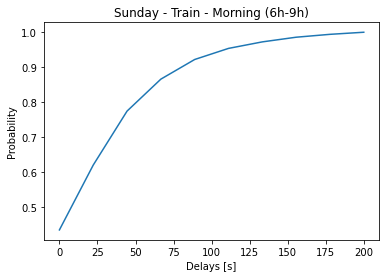

In [40]:
prob = istdaten_prob.iloc[60].tolist()
plt.plot(np.linspace(0,200,10), prob)
plt.xlabel('Delays [s]')
plt.ylabel('Probability')
plt.title('Sunday - Train - Morning (6h-9h)')
plt.savefig('exprob.png')

In [26]:
# add all the combinations
all_prob_ist = istdaten_prob.join(indexx)

In [27]:
cols = list(all_prob_ist.columns)
cols = [cols[-1]] + cols[:-1]
prob = all_prob_ist[cols]
prob.tail()

,index,0-20,20-40,40-60,60-80,80-100,100-120,120-140,140-160,160-180,180-200
58,Sun - tram 9h-16h,0.352364,0.528505,0.712264,0.815934,0.893694,0.936213,0.964047,0.981239,0.992415,1.0
59,Sun - tram 16-21h,0.335723,0.507641,0.685548,0.793389,0.872811,0.920709,0.951993,0.974619,0.989266,1.0
60,Sun - zug 6h-9h,0.434553,0.620059,0.774445,0.865898,0.922070,0.953797,0.972434,0.985784,0.994019,1.0
61,Sun - zug 9h-16h,0.420669,0.595069,0.746950,0.846460,0.908230,0.944459,0.967383,0.982162,0.992961,1.0
62,Sun - zug 16-21h,0.383600,0.558711,0.713178,0.817815,0.888342,0.929211,0.956510,0.977522,0.991040,1.0


In [73]:
prob.to_csv('prob_istdaten.csv')